## Travel Insurance Claim Detection System

### Business Problem Understanding

##### Latar Belakang

Asuransi perjalanan adalah jenis asuransi yang memberikan perlindungan selama kita melakukan perjalanan baik di dalam negeri maupun di luar negeri. Beberapa negara bahkan sudah mewajibkan para pelancong untuk memiliki asuransi perjalanan, misalnya negara-negara di Eropa dan Amerika. Besarnya premi tergantung dari pertanggungan yang diinginkan, lama perjalanan, dan tujuan perjalanan. Sebuah perusahaan yang bergerak di bidang asuransi perjalanan ingin mengetahui pemegang polis yang akan mengajukan klaim pertanggungan. Data pemegang polis pada perusahaan asuransi merupakan data historis yang terdiri dari tujuan, produk asuransi, dan lain sebagainya.

##### Problem Statement

Perusahaan perlu memprediksi pemegang polis yang akan klaim asuransi dengan tepat. Dengan prediksi yang tepat, perusahaan akan dapat menyiapkan dana asuransi dengan tepat juga sesuai dengan klaim.
1. Jika perusahaan tidak dapat menyiapkan dana untuk proses pengajuan klaim yang ada, maka dapat menurunkan kredibilitas perusahaan di masyarakat dan akan berdampak pada penjualan produk kedepannya.
2. Jika perusahaan hanya menyiapkan dana saja di setiap waktu tanpa mempertimbangkan apakah dana tersebut akan terpakai atau tidak untuk klaim nasabah, maka dana tersebut akan merugikan karena tidak menjadi instrumen investasi sehingga menyebabkan opportunity loss.

##### Goals

Perusahaan ingin memiliki kemampuan untuk memprediksi kemungkinan seorang pemegang polis akan mengajukan klaim asuransi, sehingga perusahaan dapat membuat rencana yang lebih baik dalam menangani klaim asuransi.

##### Metric Evaluation

<img src="image.webp" width="500" height="300"/>

Type 1 error : False Positive  
Konsekuensi: Persiapan dana pencairan menjadi tidak tepat sasaran dan jumlah, sehingga akan menjadi sia-sia.

Type 2 error : False Negative
Konsekuensi: Dana pencairan tidak disiapkan sehingga dapat menghambat proses klaim asuransi.

Berdasarkan konsekuensi tersebut, maka diharapkan model yang dibuat dapat mencegah False Positive dan False Negative. Perlu untuk diseimbangkan antara precision dan recallnya dari kelas positive (potential claim) sehingga metric utama yang akan digunakan adalah F1 Score.

In [1]:
# Import Library

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import category_encoders as ce
from imblearn.pipeline import Pipeline
import pycountry_convert as pc
from collections import defaultdict

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, classification_report, f1_score, roc_auc_score, RocCurveDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

#### Load Dataset

In [2]:
df = pd.read_csv('/Users/AXIOO/Downloads/Purwadhika/Module 3/Capstone 3/Travel Insurance/data_travel_insurance.csv')
df

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.00,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.00,33,No
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.70,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.00,59,No
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.00,28,No
...,...,...,...,...,...,...,...,...,...,...,...
44323,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,14,CHINA,30.0,0.00,36,Yes
44324,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,NaN,17,AUSTRALIA,79.2,47.52,47,No
44325,TST,Travel Agency,Offline,Travel Cruise Protect,M,64,THAILAND,30.0,10.50,50,No
44326,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,51,CHINA,36.0,0.00,36,No


### Data Understanding

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44328 entries, 0 to 44327
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                44328 non-null  object 
 1   Agency Type           44328 non-null  object 
 2   Distribution Channel  44328 non-null  object 
 3   Product Name          44328 non-null  object 
 4   Gender                12681 non-null  object 
 5   Duration              44328 non-null  int64  
 6   Destination           44328 non-null  object 
 7   Net Sales             44328 non-null  float64
 8   Commision (in value)  44328 non-null  float64
 9   Age                   44328 non-null  int64  
 10  Claim                 44328 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 3.7+ MB


In [4]:
df.isna().sum()

Agency                      0
Agency Type                 0
Distribution Channel        0
Product Name                0
Gender                  31647
Duration                    0
Destination                 0
Net Sales                   0
Commision (in value)        0
Age                         0
Claim                       0
dtype: int64

<Axes: >

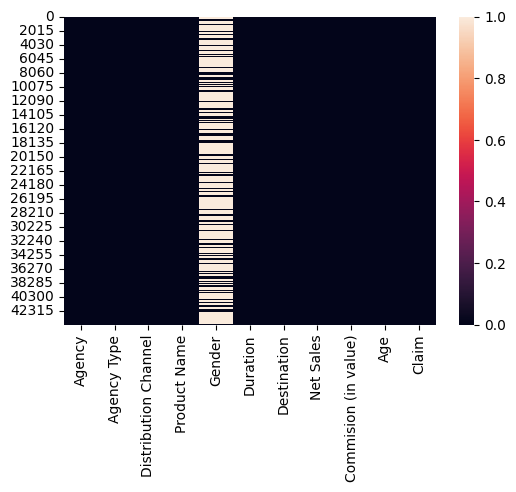

In [5]:
plt.figure(figsize=(6,4))
sns.heatmap(df.isna())

In [6]:
df.describe()

,Duration,Net Sales,Commision (in value),Age
count,44328.000000,44328.000000,44328.000000,44328.000000
mean,49.424292,40.550948,9.707692,39.925600
std,109.153961,48.661970,19.625637,13.954926
min,-1.000000,-357.500000,0.000000,0.000000
25%,9.000000,18.000000,0.000000,35.000000
50%,22.000000,26.500000,0.000000,36.000000
75%,53.000000,48.000000,11.550000,43.000000
max,4881.000000,810.000000,283.500000,118.000000


In [7]:
df.duplicated().value_counts()

False    39661
True      4667
Name: count, dtype: int64

In [8]:
pd.set_option('display.max_colwidth', 1)

listItem = []
for col in df.columns:
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((((df[col].isna().sum())/len(df))*100),2), df[col].nunique(),
                     df[col].unique()])
    
tabel1Desc = pd.DataFrame(columns=['Column Name', 'Data Type', 'Null', 'Null Percentage', 'Number of Unique', 'Unique Sample'],
                          data=listItem)
tabel1Desc

,Column Name,Data Type,Null,Null Percentage,Number of Unique,Unique Sample
0,Agency,object,0,0.00,16,"[C2B, EPX, JZI, CWT, LWC, ART, CSR, SSI, RAB, KML, TST, TTW, JWT, ADM, CCR, CBH]"
1,Agency Type,object,0,0.00,2,"[Airlines, Travel Agency]"
2,Distribution Channel,object,0,0.00,2,"[Online, Offline]"
3,Product Name,object,0,0.00,26,"[Annual Silver Plan, Cancellation Plan, Basic Plan, 2 way Comprehensive Plan, Bronze Plan, 1 way Comprehensive Plan, Rental Vehicle Excess Insurance, Single Trip Travel Protect Gold, Silver Plan, Value Plan, 24 Protect, Annual Travel Protect Gold, Comprehensive Plan, Ticket Protector, Travel Cruise Protect, Single Trip Travel Protect Silver, Individual Comprehensive Plan, Gold Plan, Annual Gold Plan, Child Comprehensive Plan, Premier Plan, Annual Travel Protect Silver, Single Trip Travel Protect Platinum, Annual Travel Protect Platinum, Spouse or Parents Comprehensive Plan, Travel Cruise Protect Family]"
4,Gender,object,31647,71.39,2,"[F, nan, M]"
5,Duration,int64,0,0.00,437,"[365, 4, 19, 20, 8, 2, 25, 90, 24, 43, 103, 376, 6, 16, 27, 34, 3, 14, 12, 31, 5, 7, 56, 29, 30, 58, 9, 38, 42, 11, 13, 40, 79, 370, 366, 26, 83, 55, 18, 100, 1, 35, 36, 75, 23, 73, 32, 232, 37, 10, 4736, 15, 17, 99, 173, 74, 82, 66, 156, 39, 95, 98, 111, 430, 53, 77, 87, 70, 151, 45, 54, 114, 118, 62, 28, 112, 326, 22, 59, 44, 21, 97, 63, 60, 51, 180, 160, 368, 65, 93, 71, 57, 0, 76, 69, 110, 146, 116, 129, 84, ...]"
6,Destination,object,0,0.00,138,"[SINGAPORE, MALAYSIA, INDIA, UNITED STATES, KOREA, REPUBLIC OF, THAILAND, GERMANY, JAPAN, INDONESIA, VIET NAM, AUSTRALIA, FINLAND, UNITED KINGDOM, SRI LANKA, SPAIN, HONG KONG, MACAO, CHINA, UNITED ARAB EMIRATES, IRAN, ISLAMIC REPUBLIC OF, TAIWAN, PROVINCE OF CHINA, POLAND, CANADA, OMAN, PHILIPPINES, GREECE, BELGIUM, TURKEY, BRUNEI DARUSSALAM, DENMARK, SWITZERLAND, NETHERLANDS, SWEDEN, MYANMAR, KENYA, CZECH REPUBLIC, FRANCE, RUSSIAN FEDERATION, PAKISTAN, ARGENTINA, TANZANIA, UNITED REPUBLIC OF, SERBIA, ITALY, CROATIA, NEW ZEALAND, PERU, MONGOLIA, CAMBODIA, QATAR, NORWAY, LUXEMBOURG, MALTA, LAO PEOPLE'S DEMOCRATIC REPUBLIC, ISRAEL, SAUDI ARABIA, AUSTRIA, PORTUGAL, NEPAL, UKRAINE, ESTONIA, ICELAND, BRAZIL, MEXICO, CAYMAN ISLANDS, PANAMA, BANGLADESH, TURKMENISTAN, BAHRAIN, KAZAKHSTAN, TUNISIA, IRELAND, ETHIOPIA, NORTHERN MARIANA ISLANDS, MALDIVES, SOUTH AFRICA, VENEZUELA, COSTA RICA, JORDAN, MALI, CYPRUS, MAURITIUS, LEBANON, KUWAIT, AZERBAIJAN, HUNGARY, BHUTAN, BELARUS, MOROCCO, ECUADOR, UZBEKISTAN, CHILE, FIJI, PAPUA NEW GUINEA, ANGOLA, FRENCH POLYNESIA, NIGERIA, MACEDONIA, THE FORMER YUGOSLAV REPUBLIC OF, NAMIBIA, GEORGIA, COLOMBIA, ...]"
7,Net Sales,float64,0,0.00,1006,"[216.0, 10.0, 22.0, 112.0, 16.0, 50.0, 78.0, 80.0, 40.0, 26.0, 252.85, 47.0, 25.0, 23.0, 20.0, 30.0, 42.0, 56.0, 19.8, 14.0, 29.7, 36.0, 31.0, 58.0, 9.9, 15.0, 21.0, 29.0, 32.0, 125.0, 48.0, 0.0, 21.04, 33.0, 204.6, 34.0, 30.55, 35.0, 49.5, 18.0, 98.0, 77.0, 69.3, 64.0, 0.32, 227.7, 48.5, -216.75, 24.0, 161.0, 99.0, 59.4, 45.0, 37.0, 44.0, 19.0, 75.0, 39.0, 17.55, -59.4, 51.0, -29.7, 80.25, 63.0, 12.0, 72.0, 53.0, 38.0, 17.0, 54.0, 69.0, 115.0, 76.3, 19.5, 29.5, 62.0, 11.0, 3.73, 79.0, 138.6, 22.5, 59.0, 5.59, 33.5, 53.25, 62.25, 93.0, -12.0, 1.03, 27.0, 56.5, 39.6, 28.0, 41.0, 97.0, 128.0, 43.0, 66.0, 26.5, 0.19, ...]"
8,Commision (in value),float64,0,0.00,915,"[54.0, 0.0, 7.7, 4.0, 9.1, 63.21, 10.5, 11.88, 17.82, 23.4, 7.5, 5.94, 43.75, 23.76, 7.36, 132.99, 9.57, 7.64, 12.25, 29.7, 6.3, 5.63, 41.58, 5.25, 0.09, 6.0, 136.62, 31.53, 54.19, 11.55, 10.15, 40.25, 59.4, 35.64, 15.75, 12.95, 28.5, 9.75, 4.39, 20.06, 18.0, 4.25, 19.07, 4.88, 7.38, 15.5, 1.05, 83.16, 14.7, 15.4, 1.57, 8.38, 13.31, 15.56, 0.29, 8.0, 36.73, 13.65, 20.3, 5.0, 10.0, 6.63, 0.05, 24.15, 29.05, 8.88, 14.0, 3.38, 15.88, 0.45, 10.89, 47.52, 0.37, 27.25, 18.13, 15.6, 70.2, 12.4, 72.94, 8.63, 4.63, 6.75, 11.25, 0.96, 53.46, 77.22, 1.13, 4.94, 1.73, 10.38, 58.45, 23.5, 6.94, 6.13, 41.42, 17.5, 13.16, 0.14, 3.23, 15.93, ...]"
9,Age,int64,0,0.00,89,"[57,

Berikut adalah beberapa informasi yang didapat berdasarkan hasil di atas:
- Terdapat 11 kolom dan 44328 baris.
- Terdiri dari 7 kolom kategorikal dan 4 kolom numerikal.
- Kolom Claim merupakan kolom target yang berisi data Yes dan No.
- Hanya kolom Gender yang memiliki *missing value* sebanyak 31647 atau sebesar 71.39% dari seluruh data.
- Terdapat data duplikat sebanyak 4667.

Kolom Kategorikal:
- Agency
- Agency Type
- Distribution Channel
- Product Name
- Destination

Kolom Numerikal:
- Duration
- Net Sales
- Commision (in Value)
- Age

### Pre-Processing

Kita akan tangani *missing value* pada kolom Gender dengan drop kolom tersebut.

In [9]:
df = df.drop('Gender', axis=1)
df.head()

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.0,54.0,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,4,MALAYSIA,10.0,0.0,33,No
2,JZI,Airlines,Online,Basic Plan,19,INDIA,22.0,7.7,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,20,UNITED STATES,112.0,0.0,59,No
4,C2B,Airlines,Online,Bronze Plan,8,SINGAPORE,16.0,4.0,28,No


Selanjutnya menghapus data yang duplikat.

In [10]:
df = df.drop_duplicates()

In [11]:
df.duplicated().value_counts()

False    39324
Name: count, dtype: int64

#### Kolom Claim

Mengubah kolom Claim dari tipe kategorikal menjadi numerikal.

In [12]:
df['Claim'] = df['Claim'].map({
    'No' : 0,
    'Yes' : 1
})

Selanjutnya kita akan cek distribusi data dari kolom target Claim.

In [13]:
df['Claim'].value_counts()

Claim
0    38651
1    673  
Name: count, dtype: int64

In [14]:
(df['Claim'].value_counts()*100/len(df)).round(2)

Claim
0    98.29
1    1.71 
Name: count, dtype: float64

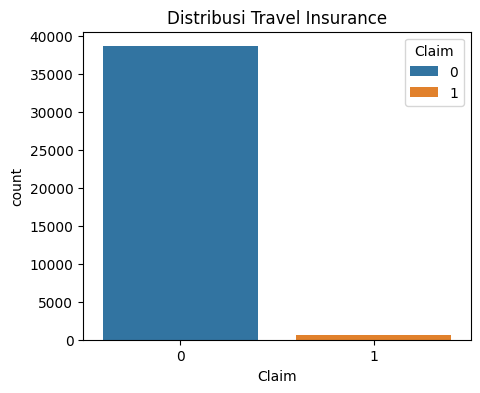

In [15]:
plt.figure(figsize=(5,4))
sns.countplot(x='Claim', data=df, hue='Claim')
plt.title('Distribusi Travel Insurance')
plt.show()

Distribusi pada kolom Claim terlihat sangat berbeda dengan jumlah '0' sebanyak 38651 dan '1' sebanyak 673. Hal tersebut menggambarkan bahwa data orang yang Claim jauh lebih sedikit dibanding data orang yang tidak Claim.

#### Outliers

Selanjutnya, kita akan melihat apakah ada outliers pada masing-masing kolom numerikal dan pengaruhnya dengan Claim.

##### Feature Duration

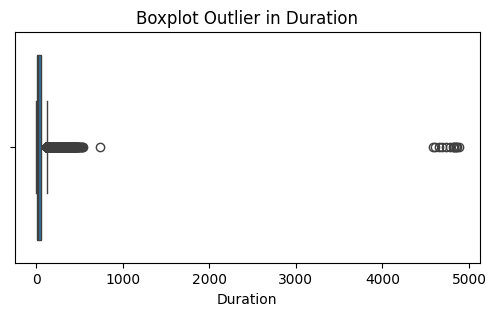

In [16]:
plt.figure(figsize=(6,3))
sns.boxplot(x=df['Duration'])
plt.title('Boxplot Outlier in Duration')
plt.show()

Terlihat durasi yang memiliki nilai yang sangat ekstrem yaitu di atas 4000, akan dicek hubungannya dengan Claim. 

In [17]:
df[(df['Duration']>4000)]

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
87,SSI,Airlines,Online,Ticket Protector,4736,SINGAPORE,0.32,0.09,48,0
4678,SSI,Airlines,Online,Ticket Protector,4857,SINGAPORE,0.32,0.09,48,0
10172,SSI,Airlines,Online,Ticket Protector,4815,SINGAPORE,0.32,0.09,48,0
12140,SSI,Airlines,Online,Ticket Protector,4652,SINGAPORE,0.32,0.09,48,0
19497,SSI,Airlines,Online,Ticket Protector,4881,SINGAPORE,0.13,0.04,48,0
20038,SSI,Airlines,Online,Ticket Protector,4844,SINGAPORE,0.32,0.09,48,0
22215,SSI,Airlines,Online,Ticket Protector,4580,SINGAPORE,0.32,0.09,48,0
25606,SSI,Airlines,Online,Ticket Protector,4685,SINGAPORE,0.32,0.09,48,0
28032,SSI,Airlines,Online,Ticket Protector,4829,SINGAPORE,0.32,0.09,48,0
37207,SSI,Airlines,Online,Ticket Protector,4609,SINGAPORE,0.32,0.09,48,0


Data kolom Duration yang memiliki value di atas 4000 tidak ada yang klaim asuransi sehingga akan kita drop.

In [18]:
df.drop(df[df['Duration'] > 4000].index, inplace=True)

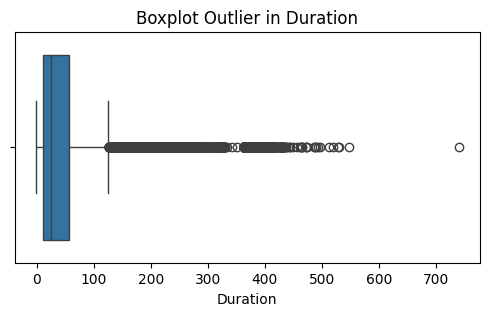

In [19]:
plt.figure(figsize=(6,3))
sns.boxplot(x=df['Duration'])
plt.title('Boxplot Outlier in Duration')
plt.show()

Masih terdapat data ekstrem pada kolom Destination yaitu di atas 100, akan dicek kembali hubungannya dengan Claim.

In [20]:
df[(df['Duration']>700)]

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
21551,C2B,Airlines,Online,Annual Silver Plan,740,SINGAPORE,0.0,54.19,36,0


In [21]:
df[(df['Duration']>100)]

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.00,54.00,57,0
11,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.00,54.00,27,0
12,JZI,Airlines,Online,Basic Plan,103,"KOREA, REPUBLIC OF",26.00,9.10,48,0
13,C2B,Airlines,Online,Annual Silver Plan,376,SINGAPORE,252.85,63.21,43,1
50,LWC,Travel Agency,Online,Annual Travel Protect Gold,370,CHINA,204.60,132.99,39,1
...,...,...,...,...,...,...,...,...,...,...
44267,C2B,Airlines,Online,Annual Gold Plan,370,SINGAPORE,333.00,83.25,40,0
44281,EPX,Travel Agency,Online,Cancellation Plan,155,UNITED STATES,14.00,0.00,52,0
44282,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,160,NEW ZEALAND,39.60,23.76,42,0
44284,EPX,Travel Agency,Online,Cancellation Plan,132,HONG KONG,13.00,0.00,36,0


Berdasarkan hasil tersebut, Duration di atas 700 akan didrop karena tidak klaim asuransi. Namun, data Duration di atas 100 tetap dipakai karena terdapat data dengan Claim kelas 1.

In [22]:
df.drop(df[df['Duration'] > 700].index, inplace=True)

##### Feature Net Sales

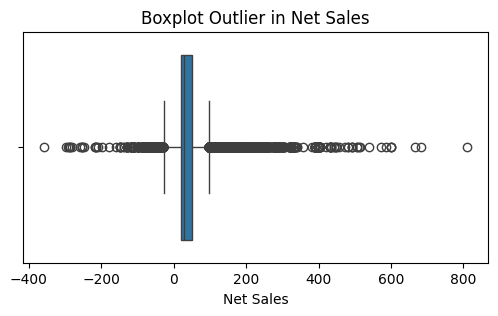

In [23]:
plt.figure(figsize=(6,3))
sns.boxplot(x=df['Net Sales'])
plt.title('Boxplot Outlier in Net Sales')
plt.show()

Terlihat terdapat nilai yang negatif pada kolom Net Sales, namun untuk pengolahan data hanya akan menggunakan data yang positif sehingga data negatif akan didrop.

In [24]:
df.drop(df[df['Net Sales'] < 0].index, inplace=True)

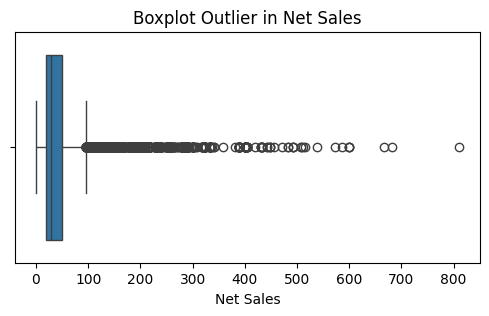

In [25]:
plt.figure(figsize=(6,3))
sns.boxplot(x=df['Net Sales'])
plt.title('Boxplot Outlier in Net Sales')
plt.show()

Data Net Sales di atas 100 akan tetap digunakan karena masih masuk akal dengan konteks kolom Net Sales.

##### Feature Commision (in value)

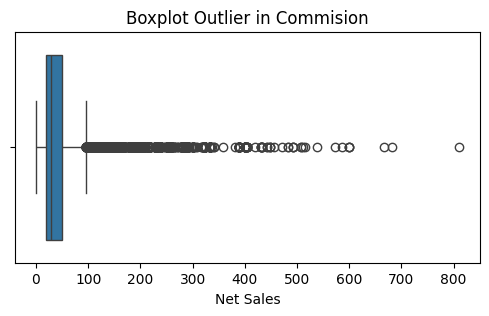

In [26]:
plt.figure(figsize=(6,3))
sns.boxplot(x=df['Net Sales'])
plt.title('Boxplot Outlier in Commision')
plt.show()

Data Commision (in value) di atas 100 akan tetap digunakan karena masih masuk akal dengan konteks kolom Commision (in value).

##### Feature Age

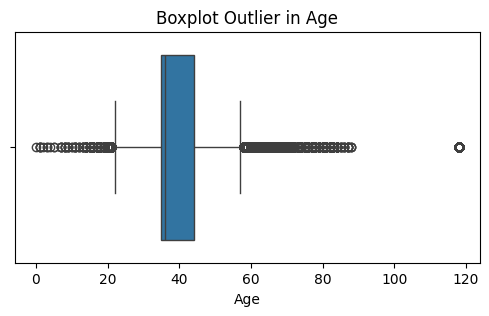

In [27]:
plt.figure(figsize=(6,3))
sns.boxplot(x=df['Age'])
plt.title('Boxplot Outlier in Age')
plt.show()

In [28]:
df[(df['Age']>100)]

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
99,ART,Airlines,Online,Value Plan,7,MALAYSIA,29.0,10.15,118,0
105,JZI,Airlines,Offline,Basic Plan,16,INDONESIA,37.0,12.95,118,0
363,JWT,Airlines,Online,Value Plan,12,INDIA,39.0,15.60,118,0
373,JWT,Airlines,Online,Value Plan,6,INDIA,39.0,15.60,118,0
727,JWT,Airlines,Online,Value Plan,76,INDIA,100.0,40.00,118,0
...,...,...,...,...,...,...,...,...,...,...
43838,JWT,Airlines,Online,Value Plan,67,INDIA,200.0,80.00,118,0
43856,JWT,Airlines,Online,Value Plan,10,INDIA,50.0,20.00,118,1
43928,JWT,Airlines,Online,Value Plan,83,INDIA,180.0,72.00,118,0
44089,JWT,Airlines,Online,Value Plan,42,INDIA,31.0,12.40,118,0


In [29]:
df[(df['Age']>100) & (df['Claim']==1)]

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
5398,JWT,Airlines,Online,Value Plan,25,INDIA,78.0,31.20,118,1
11377,EPX,Travel Agency,Offline,2 way Comprehensive Plan,20,AUSTRALIA,37.0,0.00,118,1
15158,EPX,Travel Agency,Offline,1 way Comprehensive Plan,18,CHINA,33.0,0.00,118,1
24732,JWT,Airlines,Online,Value Plan,81,INDIA,124.0,49.60,118,1
32456,CCR,Travel Agency,Offline,Comprehensive Plan,15,THAILAND,29.0,9.57,118,1
35061,JWT,Airlines,Online,Value Plan,51,INDIA,78.0,31.20,118,1
43856,JWT,Airlines,Online,Value Plan,10,INDIA,50.0,20.00,118,1


Data kolom Age yang di atas 100 yang tidak klaim asuransi akan didrop.

In [30]:
df.drop(df[(df['Age'] > 100) & (df['Claim']==0)].index, inplace=True)

In [31]:
df[(df['Age']>100)]

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
5398,JWT,Airlines,Online,Value Plan,25,INDIA,78.0,31.20,118,1
11377,EPX,Travel Agency,Offline,2 way Comprehensive Plan,20,AUSTRALIA,37.0,0.00,118,1
15158,EPX,Travel Agency,Offline,1 way Comprehensive Plan,18,CHINA,33.0,0.00,118,1
24732,JWT,Airlines,Online,Value Plan,81,INDIA,124.0,49.60,118,1
32456,CCR,Travel Agency,Offline,Comprehensive Plan,15,THAILAND,29.0,9.57,118,1
35061,JWT,Airlines,Online,Value Plan,51,INDIA,78.0,31.20,118,1
43856,JWT,Airlines,Online,Value Plan,10,INDIA,50.0,20.00,118,1


Lalu akan dilakukan Binning untuk mengelompokkan umur.

In [32]:
bins = [0, 18, 35, 50, 65, 100]
labels = ['<18', '18-35', '36-50', '51-65', '65+']
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels)

In [33]:
df.head()

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim,AgeGroup
0,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.0,54.0,57,0,51-65
1,EPX,Travel Agency,Online,Cancellation Plan,4,MALAYSIA,10.0,0.0,33,0,18-35
2,JZI,Airlines,Online,Basic Plan,19,INDIA,22.0,7.7,26,0,18-35
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,20,UNITED STATES,112.0,0.0,59,0,51-65
4,C2B,Airlines,Online,Bronze Plan,8,SINGAPORE,16.0,4.0,28,0,18-35


Untuk kolom kategorikal, akan dilakukan crosstab pada setiap kolom untuk melihat persentase Claim pada setiap data unique. Berdasarkan hasil tersebut akan dilakukan kategorisasi ulang pada kolom dengan banyak data unique.

#### Feature Agency

In [34]:
(pd.crosstab(index = df['Agency'], columns=df['Claim'], normalize=True)*100).round(4) 

Claim,0,1
Agency,,
ADM,0.1119,0.0000
ART,0.4919,0.0000
C2B,12.7547,1.0488
CBH,0.1718,0.0026
CCR,0.2446,0.0052
CSR,0.1744,0.0026
CWT,14.0351,0.1666
EPX,53.8634,0.3461
JWT,0.0000,0.0104


Berdasarkan hasil tersebut, Agency yang berpengaruh terhadap Claim kelas 1 adalah C2B, CWT, EPX, dan untuk yang lainnya akan dikelompokkan menjadi Others.

In [35]:
def cat_agency(x):
    if x in ['C2B', 'CWT', 'EPX']:
        return x
    else: 
        return 'Others'
    
df['Agency'] = df['Agency'].apply(cat_agency)
df['Agency'].unique()

array(['C2B', 'EPX', 'Others', 'CWT'], dtype=object)

#### Feature Agency Type

In [36]:
(pd.crosstab(index = df['Agency Type'], columns=df['Claim'], normalize=True)*100).round(4)

Claim,0,1
Agency Type,,
Airlines,26.9616,1.1321
Travel Agency,71.2869,0.6194


Karena pada kolom Agency Type data unique hanya ada 2, maka semua akan dipakai.

#### Feature Distribution Channel

In [37]:
(pd.crosstab(index = df['Distribution Channel'], columns=df['Claim'], normalize=True)*100).round(4)

Claim,0,1
Distribution Channel,,
Offline,1.6760,0.0286
Online,96.5725,1.7228


Semua data pada kolom Distribution Channel juga akan dipakai karena data unique hanya ada 2.

#### Feature Product Name

In [38]:
(pd.crosstab(index = df['Product Name'], columns=df['Claim'], normalize=True)*100).round(4)

Claim,0,1
Product Name,,
1 way Comprehensive Plan,4.7651,0.0182
2 way Comprehensive Plan,20.7261,0.2472
24 Protect,0.4346,0.0000
Annual Gold Plan,0.3097,0.0416
Annual Silver Plan,1.9050,0.2785
Annual Travel Protect Gold,0.1431,0.0182
Annual Travel Protect Platinum,0.0833,0.0052
Annual Travel Protect Silver,0.1431,0.0104
Basic Plan,9.2934,0.0416


Berdasarkan hasil tersebut, Product Name yang berpengaruh terhadap Claim kelas 1 adalah 2 way Comprehensive Plan, Annual Silver Plan, Bronze Plan, Rental Vehicle Excess Insurance, Silver Plan, dan untuk yang lainnya akan dikelompokkan menjadi Others. 

In [39]:
def recat_product(x):
    if x in ['2 way Comprehensive Plan', 'Annual Silver Plan', 'Bronze Plan', 'Rental Vehicle Excess Insurance', 'Silver Plan']:
        return x
    else:
        return 'Others'
    
df['Product Name'] = df['Product Name'].apply(recat_product)

In [40]:
df['Product Name'].unique()

array(['Annual Silver Plan', 'Others', '2 way Comprehensive Plan',
       'Bronze Plan', 'Rental Vehicle Excess Insurance', 'Silver Plan'],
      dtype=object)

#### Feature Destination

Karena data unique pada kolom Destination ada banyak yaitu 138, maka akan diubah dengan mengelompokkan negara berdasarkan benuanya.

In [41]:
def country_to_continent(country_name):
  try:
      country_alpha2 = pc.country_name_to_country_alpha2(country_name.title())
      country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
      country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
      return country_continent_name
  except:
    return 'Other'
  
df['Destination'] = df['Destination'].apply(country_to_continent)

In [42]:
df['Destination'].unique() 

array(['Asia', 'North America', 'Europe', 'Oceania', 'Other', 'Africa',
       'South America'], dtype=object)

In [43]:
(pd.crosstab(index = df['Destination'], columns=df['Claim'], normalize=True)*100).round(4)

Claim,0,1
Destination,,
Africa,0.5075,0.0052
Asia,74.2876,1.4444
Europe,8.5830,0.1119
North America,5.3116,0.0885
Oceania,7.0683,0.0885
Other,2.1470,0.0130
South America,0.3435,0.0000


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38425 entries, 0 to 44327
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Agency                38425 non-null  object  
 1   Agency Type           38425 non-null  object  
 2   Distribution Channel  38425 non-null  object  
 3   Product Name          38425 non-null  object  
 4   Duration              38425 non-null  int64   
 5   Destination           38425 non-null  object  
 6   Net Sales             38425 non-null  float64 
 7   Commision (in value)  38425 non-null  float64 
 8   Age                   38425 non-null  int64   
 9   Claim                 38425 non-null  int64   
 10  AgeGroup              38417 non-null  category
dtypes: category(1), float64(2), int64(3), object(5)
memory usage: 3.3+ MB


In [45]:
pd.set_option('display.max_colwidth', 1)

listItem = []
for col in df.columns:
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((((df[col].isna().sum())/len(df))*100),2), df[col].nunique(),
                     df[col].unique()])
    
tabel1Desc = pd.DataFrame(columns=['Column Name', 'Data Type', 'Null', 'Null Percentage', 'Number of Unique', 'Unique Sample'],
                          data=listItem)
tabel1Desc

,Column Name,Data Type,Null,Null Percentage,Number of Unique,Unique Sample
0,Agency,object,0,0.00,4,"[C2B, EPX, Others, CWT]"
1,Agency Type,object,0,0.00,2,"[Airlines, Travel Agency]"
2,Distribution Channel,object,0,0.00,2,"[Online, Offline]"
3,Product Name,object,0,0.00,6,"[Annual Silver Plan, Others, 2 way Comprehensive Plan, Bronze Plan, Rental Vehicle Excess Insurance, Silver Plan]"
4,Duration,int64,0,0.00,421,"[365, 4, 19, 20, 8, 2, 25, 90, 24, 43, 103, 376, 6, 16, 27, 34, 3, 14, 12, 31, 5, 7, 56, 29, 30, 58, 9, 38, 42, 11, 13, 40, 79, 370, 366, 26, 83, 55, 18, 100, 1, 35, 36, 75, 23, 73, 32, 232, 37, 10, 15, 17, 99, 173, 74, 82, 66, 156, 39, 95, 98, 111, 53, 87, 70, 151, 45, 54, 114, 118, 62, 28, 112, 326, 22, 59, 44, 21, 97, 63, 60, 51, 180, 160, 368, 65, 93, 71, 0, 76, 69, 110, 146, 116, 129, 84, 33, 149, 68, 64, ...]"
5,Destination,object,0,0.00,7,"[Asia, North America, Europe, Oceania, Other, Africa, South America]"
6,Net Sales,float64,0,0.00,869,"[216.0, 10.0, 22.0, 112.0, 16.0, 50.0, 78.0, 80.0, 40.0, 26.0, 252.85, 47.0, 25.0, 23.0, 20.0, 30.0, 42.0, 56.0, 19.8, 14.0, 29.7, 36.0, 31.0, 58.0, 9.9, 15.0, 21.0, 29.0, 32.0, 125.0, 48.0, 0.0, 21.04, 33.0, 204.6, 34.0, 30.55, 35.0, 49.5, 18.0, 98.0, 77.0, 69.3, 64.0, 227.7, 48.5, 24.0, 161.0, 99.0, 59.4, 45.0, 44.0, 19.0, 75.0, 39.0, 17.55, 51.0, 80.25, 63.0, 12.0, 72.0, 53.0, 38.0, 17.0, 54.0, 37.0, 69.0, 115.0, 76.3, 19.5, 29.5, 62.0, 11.0, 3.73, 79.0, 138.6, 22.5, 59.0, 5.59, 33.5, 53.25, 62.25, 93.0, 1.03, 27.0, 56.5, 39.6, 28.0, 41.0, 97.0, 128.0, 43.0, 66.0, 26.5, 0.19, 83.0, 35.5, 13.5, 63.5, 73.0, ...]"
7,Commision (in value),float64,0,0.00,884,"[54.0, 0.0, 7.7, 4.0, 9.1, 63.21, 10.5, 11.88, 17.82, 23.4, 7.5, 5.94, 43.75, 23.76, 7.36, 132.99, 9.57, 7.64, 12.25, 29.7, 6.3, 5.63, 41.58, 5.25, 6.0, 136.62, 31.53, 11.55, 40.25, 59.4, 35.64, 15.75, 28.5, 9.75, 4.39, 20.06, 18.0, 4.25, 19.07, 4.88, 7.38, 15.5, 1.05, 83.16, 14.7, 15.4, 1.57, 8.38, 13.31, 15.56, 0.29, 8.0, 36.73, 13.65, 20.3, 5.0, 10.0, 6.63, 0.05, 24.15, 29.05, 8.88, 14.0, 3.38, 15.88, 0.45, 10.89, 47.52, 0.37, 27.25, 18.13, 70.2, 12.4, 72.94, 8.63, 4.63, 6.75, 11.25, 0.96, 53.46, 77.22, 1.13, 4.94, 1.73, 10.38, 58.45, 23.5, 6.94, 6.13, 41.42, 17.5, 13.16, 0.14, 12.95, 3.23, 15.93, 3.74, 46.96, 16.25, 9.2, ...]"
8,Age,int64,0,0.00,89,"[57, 33, 26, 59, 28, 36, 22, 39, 27, 48, 43, 51, 65, 47, 35, 54, 23, 46, 58, 42, 31, 29, 37, 68, 8, 32, 61, 49, 56, 25, 50, 34, 38, 44, 45, 53, 20, 30, 69, 52, 40, 41, 70, 76, 74, 66, 63, 55, 21, 60, 75, 24, 62, 73, 64, 71, 5, 14, 72, 84, 81, 16, 19, 67, 83, 13, 79, 18, 9, 80, 17, 82, 78, 15, 118, 77, 87, 88, 11, 12, 86, 7, 10, 2, 3, 1, 4, 85, 0]"
9,Claim,int64,0,0.00,2,"[0, 1]"


Data awal berisi 44328 baris dan 11 kolom dan setelah drop *missing values* dan outliers yang tidak diperlukan serta binning pada kolomh Age, data menjadi 38425 baris dan 11 kolom dengan kolom Age yang berubah menjadi AgeGroup.

In [46]:
# save to csv
df.to_csv('Data Train Travel_Insurance.csv', index=False)

In [47]:
X = df.drop(columns=['Claim']).copy()
y = df['Claim'].copy()

#### Encoding

Selanjutnya kita akan melakukan encoding pada kolom kategorikal.

In [48]:
df_encode = pd.get_dummies(df, columns=['Agency', 'Agency Type', 'Distribution Channel', 'Product Name', 'Destination', 'AgeGroup'  ], dtype=int, drop_first=True)

In [49]:
df_encode.head()

,Duration,Net Sales,Commision (in value),Age,Claim,Agency_CWT,Agency_EPX,Agency_Others,Agency Type_Travel Agency,Distribution Channel_Online,...,Destination_Asia,Destination_Europe,Destination_North America,Destination_Oceania,Destination_Other,Destination_South America,AgeGroup_18-35,AgeGroup_36-50,AgeGroup_51-65,AgeGroup_65+
0,365,216.0,54.0,57,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
1,4,10.0,0.0,33,0,0,1,0,1,1,...,1,0,0,0,0,0,1,0,0,0
2,19,22.0,7.7,26,0,0,0,1,0,1,...,1,0,0,0,0,0,1,0,0,0
3,20,112.0,0.0,59,0,0,1,0,1,1,...,0,0,1,0,0,0,0,0,1,0
4,8,16.0,4.0,28,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0


In [50]:
X = df_encode.drop(columns=['Claim']).copy()
y = df_encode['Claim'].copy()

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Modeling
Beberapa model akan dicoba untuk mengetahui model apa yang memiliki nilai paling bagus dan sesuai untuk kasus ini. Untuk scaling data, karena terdapat outliers pada data ini, maka akan menggunakan Robust Scaler. 

Selain itu, karena jumlah kelas dari target Claim sangat tidak seimbang, maka perlu dilakukan balancing. Beberapa strategi balancing akan dicoba pada setiap model untuk mengetahui strategi mana yang paling tepat.

In [52]:
def evaluate_models_with_pipeline(X_train, y_train, cv=5):
    methods = {
        'No Handling': None,
        'SMOTE': SMOTE(random_state=42),
        'RandomOverSampler': RandomOverSampler(random_state=42),
        'RandomUnderSampler': RandomUnderSampler(random_state=42)
    }

    models = {
        'Random Forest': RandomForestClassifier(random_state=42),
        'Logistic Regression': LogisticRegression(random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'KNN': KNeighborsClassifier()
    }

    results = defaultdict(dict)

    for method_name, sampler in methods.items():
        print(f"\n Handling method: {method_name}")
        for model_name, model in models.items():
            steps = [('scaler', RobustScaler())]
            if sampler:
                steps.append(('sampler', sampler))
            steps.append(('classifier', model))

            pipeline = Pipeline(steps=steps)
            cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1')
            mean_score = cv_scores.mean()
            results[method_name][model_name] = mean_score
            print(f"  {model_name}: F1 CV Mean = {mean_score:.4f}")

    return pd.DataFrame(results)

results_df_pipeline = evaluate_models_with_pipeline(X_train, y_train, cv=5)
print("\n Perbandingan F1-score:\n")
results_df_pipeline.T.round(4)


 Handling method: No Handling
  Random Forest: F1 CV Mean = 0.0180
  Logistic Regression: F1 CV Mean = 0.0036
  Decision Tree: F1 CV Mean = 0.0915
  KNN: F1 CV Mean = 0.0209

 Handling method: SMOTE
  Random Forest: F1 CV Mean = 0.0884
  Logistic Regression: F1 CV Mean = 0.1134
  Decision Tree: F1 CV Mean = 0.0784
  KNN: F1 CV Mean = 0.0818

 Handling method: RandomOverSampler
  Random Forest: F1 CV Mean = 0.0487
  Logistic Regression: F1 CV Mean = 0.1147
  Decision Tree: F1 CV Mean = 0.0652
  KNN: F1 CV Mean = 0.0871

 Handling method: RandomUnderSampler
  Random Forest: F1 CV Mean = 0.0851
  Logistic Regression: F1 CV Mean = 0.1163
  Decision Tree: F1 CV Mean = 0.0660
  KNN: F1 CV Mean = 0.0868

 Perbandingan F1-score:



,Random Forest,Logistic Regression,Decision Tree,KNN
No Handling,0.0180,0.0036,0.0915,0.0209
SMOTE,0.0884,0.1134,0.0784,0.0818
RandomOverSampler,0.0487,0.1147,0.0652,0.0871
RandomUnderSampler,0.0851,0.1163,0.0660,0.0868


Berdasarkan hasil tersebut, SMOTE yang akan digunakan untuk handling imbalance data.

In [53]:
results_test_before_tuning = []

methods_for_test = {
    'SMOTE': SMOTE(random_state=42)
}

models_for_test = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier()
}

for method_name, sampler in methods_for_test.items():
    for model_name, model in models_for_test.items():
        steps = [('scaler', RobustScaler()), ('sampler', sampler), ('classifier', model)]
        pipeline = Pipeline(steps=steps)
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)

        results_test_before_tuning.append({
            'Model': model_name,
            'F1 Score': f1,
            'Precision': precision,
            'Recall': recall,
        })

results_df_test_before_tuning = pd.DataFrame(results_test_before_tuning)
results_df_test_before_tuning.round(4)
# print("\n Evaluasi Test Set Sebelum Tuning:\n")
# print(results_df_test_before_tuning.pivot(index='Model', columns='Handling Method').round(4))

,Model,F1 Score,Precision,Recall
0,Random Forest,0.1198,0.1005,0.1481
1,Logistic Regression,0.1126,0.0614,0.6741
2,Decision Tree,0.0743,0.0558,0.1111
3,KNN,0.1048,0.0598,0.4222


Dari hasil tersebut diketahui bahwa model Random Forest memiliki F1 score yang paling baik. Oleh karena itu model Random Forest akan dipilih untuk kasus ini namun akan kita coba lakukan hyperparameter tuning terlebih dulu untuk melihat hasil yang paling baik.

### Hyperparameter Tuning
Dilakukan untuk mendapatkan parameter model terbaik. Pada kasus ini akan menggunakan RandomizedSearchCV.

In [55]:
param_dist_rf = {
    'classifier__n_estimators': [100, 200, 300, 400],
    'classifier__max_depth': [10, 20, 30, None],
    'classifier__min_samples_split': [2, 5, 10]
}

pipeline_rf = Pipeline(steps=[
    ('scaler', RobustScaler()),
    ('sampler', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

random_search_rf = RandomizedSearchCV(pipeline_rf, param_distributions=param_dist_rf, cv=5, scoring='f1', n_iter=10, random_state=42, n_jobs=-1)
random_search_rf.fit(X_train, y_train)

print("\n Best Parameters (Random Forest):", random_search_rf.best_params_)
print("Best F1 Score:", random_search_rf.best_score_)


 Best Parameters (Random Forest): {'classifier__n_estimators': 100, 'classifier__min_samples_split': 5, 'classifier__max_depth': 10}
Best F1 Score: 0.13399602289706306


In [56]:
y_pred_best_rf = random_search_rf.best_estimator_.predict(X_test)
print("\n Random Forest Sesudah Tuning:")
print(classification_report(y_test, y_pred_best_rf))

print("Final Test Set F1 Scores:")
print(f"Random Forest: {f1_score(y_test, y_pred_best_rf):.4f}")


 Random Forest Sesudah Tuning:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      7550
           1       0.08      0.53      0.13       135

    accuracy                           0.88      7685
   macro avg       0.53      0.71      0.54      7685
weighted avg       0.97      0.88      0.92      7685

Final Test Set F1 Scores:
Random Forest: 0.1347


Sebelum menggunakan hyperparameter tuning:

In [57]:
print((results_df_test_before_tuning[results_df_test_before_tuning['Model'] == 'Random Forest']['F1 Score'].values[0]).round(4))

0.1198


Setelah menggunakan hyperparameter tuning:

In [58]:
print(f"{f1_score(y_test, y_pred_best_rf):.4f}")

0.1347


Terlihat F1 score sesudah menggunakan hyperparameter tuning menjadi lebih baik dari sebelum menggunakannya. Berdasarkan hasil perbandingan tersebut, maka model yang akan digunakan adalah yang telah menggunakan hyperparameter tuning.


 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.89      0.94      7550
           1       0.08      0.53      0.13       135

    accuracy                           0.88      7685
   macro avg       0.53      0.71      0.54      7685
weighted avg       0.97      0.88      0.92      7685



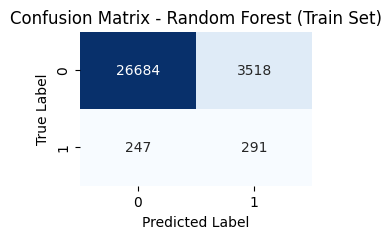

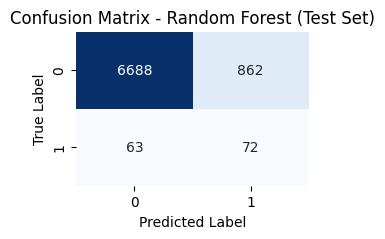

In [59]:
from sklearn.model_selection import cross_val_predict

train_preds_rf = cross_val_predict(random_search_rf.best_estimator_, X_train, y_train, cv=5)
test_preds_rf = y_pred_best_rf

print("\n Classification Report:\n", classification_report(y_test, y_pred_best_rf))

# Visualisasi Confusion Matrix Random Forest
def plot_conf_matrix(cm, title):
    plt.figure(figsize=(3,2))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

# Visualisasi Train dan Test
cm_train_rf = confusion_matrix(y_train, train_preds_rf)
cm_test_rf = confusion_matrix(y_test, test_preds_rf)

plot_conf_matrix(cm_train_rf, 'Confusion Matrix - Random Forest (Train Set)')
plot_conf_matrix(cm_test_rf, 'Confusion Matrix - Random Forest (Test Set)')

### Save to Pickle

In [60]:
pickle.dump(y_pred_best_rf, open('ClaimDetector_RandomForest.pkl', 'wb'))

### Kesimpulan

Berdasarkan hasil tersebut, model Random Forest setelah hyperparameter tuning sudah cukup baik untuk digunakan. Walau hasil F1 score hanya sebesar 13%, namun pada kondisi imbalance yang ekstrem dimana kelas positif hanya 1.7%, model masih layak untuk digunakan.

Model sudah cukup baik dalam mendeteksi klaim yang terjadi dengan nilai recall sebesar 53%, namun masih perlu optimasi lebih lanjut agar agar prediksi bisa lebih akurat.

### Rekomendasi

1.  Memakai GridSearchCV untuk Hyperparameter Tuningnya untuk kemungkinan F1 score yang lebih baik, namun dengan konsekuensi waktu fitting yang akan menjadi lebih lama.
2. Dalam melakukan handling imbalance data bisa kombinasikan dengan metode lain yang kemungkinan dapat mengoptimalkan model.
3. Mencoba lebih banyak variasi model, terutama yang lebih robust terhadap imbalance data. 
